## ✅ 1. Dataset Ingestion

In [2]:
import pandas as pd

# Load IMDb dataset (example from Kaggle)
df = pd.read_csv('IMDB Dataset.csv')  # Columns: review, sentiment

# Preview data
# df = df_ori.head(10)
print(df.head())
print(df['sentiment'].value_counts())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


## ✅ 2. Preprocessing Pipeline

In [3]:
# ! pip install nltk emoji langdetect textblob
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')\
# nltk.download('punkt_tab')

In [4]:
import re
import nltk
import emoji
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, spell_correct=False):
    try:

        # 2. Lowercase
        text = text.lower()

        # 3. Remove emojis → convert them to text
        text = emoji.demojize(text)

        # 4. Regex cleanup (remove non-alphabetic)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)

        # 5. Tokenization
        tokens = nltk.word_tokenize(text)

        # 6. Stopword removal + lemmatization
        tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]

        # 7. Spelling correction (optional, slow)
        if spell_correct:
            tokens = [str(TextBlob(word).correct()) for word in tokens]

        return ' '.join(tokens)

    except:
        return ""




In [5]:
df['cleaned'] = df['review'].apply(lambda x: preprocess_text(x, spell_correct=False))

In [6]:
df.head(4)

,review,sentiment,cleaned
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching episode hooked...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...


## ✅ Step 3: Text to Vector (Vectorization)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned'])


## Word2Vec Vectorization

In [8]:
# !pip install gensim

In [9]:
from gensim.models import Word2Vec
import numpy as np

# Tokenize each review
tokenized = df['cleaned'].apply(lambda x: x.split())

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=2)

# Function to get average word2vec for a document
def avg_w2v_vector(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec

# Apply to all reviews
X_w2v = np.array([avg_w2v_vector(doc, w2v_model) for doc in tokenized])


## RoBERTa Vectorization (Using Hugging Face)

In [10]:
# !pip install transformers
# !pip install torch

In [11]:
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm

# Load tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')
model.eval()  # Inference only

# Function to get CLS token vector
def roberta_encode(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] token
        embeddings.append(cls_embedding)
    return np.array(embeddings)

X_roberta = roberta_encode(df['cleaned'].tolist())


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 50000/50000 [55:26<00:00, 15.03it/s]   


## ✅ Step 4: Traditional ML Modeling with Hyperparameter Tuning

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Target labels (0 = negative, 1 = positive)
y = df['sentiment'].map({'positive': 1, 'negative': 0})


In [13]:
df.head(2)

,review,sentiment,cleaned
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching episode hooked...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...


### 🔹 1. Logistic Regression (TF-IDF)

In [14]:
X_tfidf[:3].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Best params:", grid_lr.best_params_)
y_pred = grid_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best params: {'C': 1, 'solver': 'liblinear'}
Accuracy: 0.8877
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [17]:
X_train.shape

(40000, 5000)

In [18]:
X_train[:3].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 🔹 2. Multinomial Naive Bayes (Only for TF-IDF)

In [19]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Accuracy: 0.8553
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4961
           1       0.85      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### 🔹 3. SVM (TF-IDF)

In [20]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print("Best params:", grid_svm.best_params_)
y_pred_svm = grid_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Best params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.8925
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

In [22]:
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Best params:", grid_lr.best_params_)
y_pred = grid_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best params: {'C': 1, 'solver': 'liblinear'}
Accuracy: 0.8657
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4961
           1       0.86      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [23]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print("Best params:", grid_svm.best_params_)
y_pred_svm = grid_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Best params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 0.8759
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4961
           1       0.87      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_roberta, y, test_size=0.2, random_state=42)

In [25]:
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid, cv=3, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("Best params:", grid_lr.best_params_)
y_pred = grid_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best params: {'C': 10, 'solver': 'liblinear'}
Accuracy: 0.8517
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [26]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

svm = SVC()
grid_svm = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)

print("Best params:", grid_svm.best_params_)
y_pred_svm = grid_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Best params: {'C': 10, 'kernel': 'linear'}
Accuracy: 0.853
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.86      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Bigger models

### XGBoost with TF-IDF

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


/opt/homebrew/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:40:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8566
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4961
           1       0.84      0.88      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### Random Forest with Word2Vec

In [28]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, max_depth=20)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.843
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4961
           1       0.83      0.87      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



### MLPClassifier (Neural Net) with RoBERTa

In [29]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_roberta, y, test_size=0.2, random_state=42)

mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=20, activation='relu')
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8526
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      4961
           1       0.83      0.89      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



/opt/homebrew/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [31]:
# ! pip install tensorflow


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the cleaned text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])

sequences = tokenizer.texts_to_sequences(df['cleaned'])
padded = pad_sequences(sequences, padding='post', maxlen=100)

# Labels
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values


In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=64, input_length=100))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 106ms/step - accuracy: 0.6432 - loss: 0.5885 - val_accuracy: 0.8745 - val_loss: 0.3121
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.8934 - loss: 0.2856 - val_accuracy: 0.8666 - val_loss: 0.3066
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.9194 - loss: 0.2288 - val_accuracy: 0.8724 - val_loss: 0.3596
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 116ms/step - accuracy: 0.9353 - loss: 0.1928 - val_accuracy: 0.8751 - val_loss: 0.3179
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.9453 - loss: 0.1633 - val_accuracy: 0.8698 - val_loss: 0.3646


In [36]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8669 - loss: 0.3671
Test Accuracy: 0.8698


In [40]:
# !pip install WordCloud

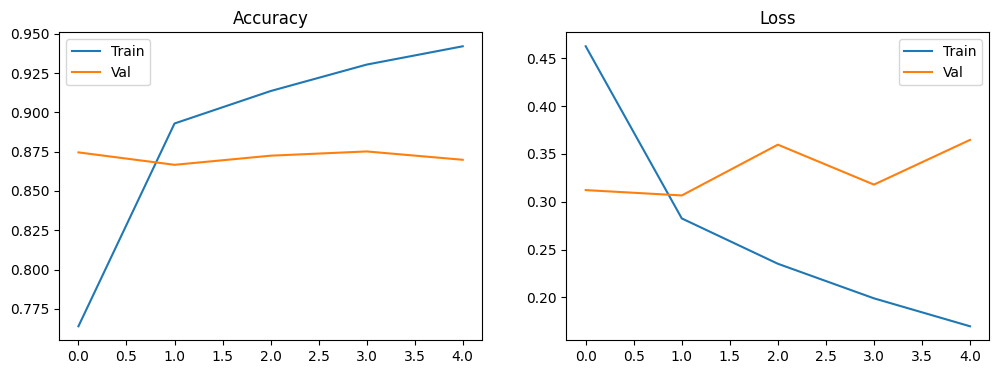

In [45]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title("Loss")
    plt.legend()
    
    plt.show()

plot_history(history)


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


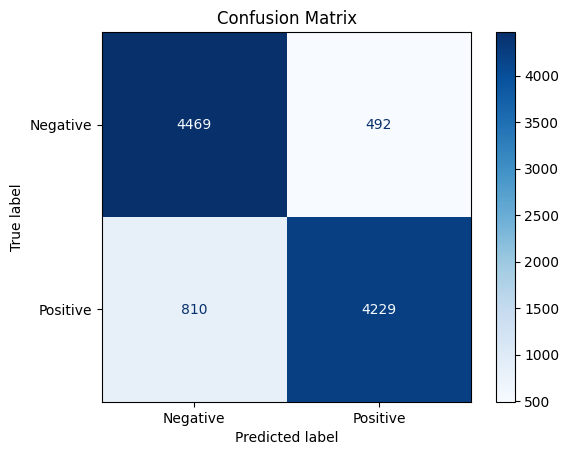

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.round(y_pred_probs).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


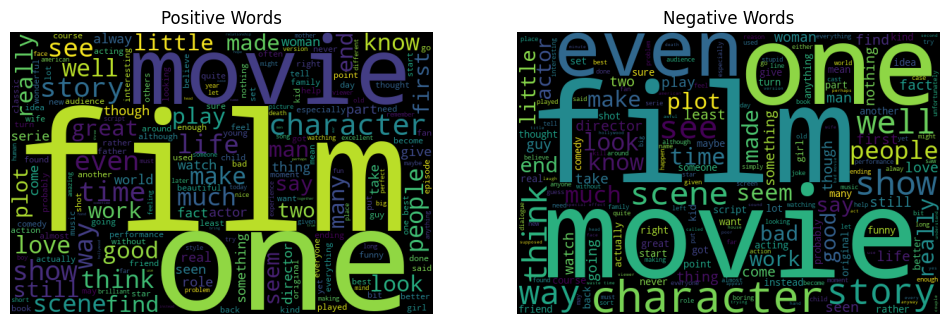

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Get positive and negative reviews
pos_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned'])
neg_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned'])

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=600, height=400).generate(pos_text))
plt.title("Positive Words")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=600, height=400).generate(neg_text))
plt.title("Negative Words")
plt.axis('off')
plt.show()


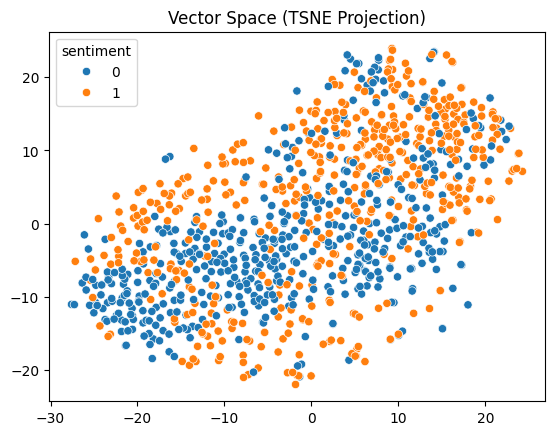

In [43]:
from sklearn.manifold import TSNE
import seaborn as sns

# Example with Word2Vec or RoBERTa
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_vis = tsne.fit_transform(X_w2v[:1000])  # or X_roberta[:1000]

sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=y[:1000])
plt.title("Vector Space (TSNE Projection)")
plt.show()


In [47]:
from transformers import AutoTokenizer, AutoModel
from bertviz import head_view
import torch

# Load model and tokenizer (you can replace with 'bert-base-uncased')
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Example sentence
text = "The plot was boring but the visuals were amazing."

# Tokenize
inputs = tokenizer.encode_plus(text, return_tensors="pt")
input_ids = inputs['input_ids']

# Forward pass to get attention weights
outputs = model(**inputs)
attention = outputs.attentions  # List of 12 layers (each with 12 heads)

# Visualize
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
head_view(attention, tokens)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>